In [1]:
import gymnasium as gym
import ale_py  # Ensure Atari environments work
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import random
from gymnasium.wrappers import GrayscaleObservation, ResizeObservation
from collections import deque
import torch.nn.functional as F

In [2]:
import numpy as np
from collections import deque
from gymnasium import spaces

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.

        Returns lazy array, which is much more memory efficient.

        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob, info = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob(), info

    def step(self, action):
        ob, reward, done, truncated, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, truncated, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.

        This object should only be converted to numpy array before being passed to the model.

        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.stack(self._frames)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[frames.ndim - 1]

    def frame(self, i):
        return self._force()[..., i]


def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env

In [3]:
class DQN_CNN(nn.Module):
    def __init__(self, input_channels, action_dim):
        super(DQN_CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),  # Output: (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # Output: (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # Output: (64, 7, 7)
            nn.ReLU()
        )


        self.fc_layers = nn.Sequential(
            nn.Linear(64*7*7, 512),  # Flattened CNN features
            nn.ReLU(),
            nn.Linear(512, action_dim)  # Output Q-values for each action
        )

    def forward(self, x):
        x = self.conv_layers(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc_layers(x)
        return x

In [4]:
def select_action(env, model, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Random action (exploration)

    state = torch.FloatTensor(state).unsqueeze(0) / 255.0  # Normalize pixels
    state = state.to(device)
    with torch.no_grad():
        return model(state).argmax().item()

def train(model, target_model, buffer, optimizer, batch_size, gamma):
    if buffer.size() < batch_size:
        return

    # Sample batch from experience replay
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    states = states.to(device)
    actions = actions.to(device)
    rewards = rewards.to(device)
    next_states = next_states.to(device)
    dones = dones.to(device)

    # Compute Q-values for current states
    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)  # Select Q-values of taken actions

    # Compute next Q-values from the target network
    next_q_values = target_model(next_states).max(1)[0].detach()  # Max Q-value of next state

    dones = dones.to(torch.bool)
    # Zero next_q_values for terminal states
    next_q_values[dones] = 0.0

    # Compute target Q-values
    target_q_values = rewards + gamma * next_q_values

    # Compute loss using Huber loss (smooth_l1_loss)
    loss = F.smooth_l1_loss(q_values, target_q_values.detach())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
    optimizer.step()


In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((
            state,
            action,
            int(reward),
            next_state,
            bool(done)
        ))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)

        return (
            torch.FloatTensor(np.array(state)) / 255.0,  # Normalize pixels
            torch.LongTensor(action),
            torch.FloatTensor(reward),
            torch.FloatTensor(np.array(next_state)) / 255.0,
            torch.FloatTensor(done)
        )

    def size(self):
        return len(self.buffer)

A.L.E: Arcade Learning Environment (version 0.10.2+c9d4b19)
[Powered by Stella]


Observation space: Box(0, 255, (84, 336), uint8)
Episode 0, Reward: 11.0, Epsilon: 1.000
Episode 1, Reward: 7.0, Epsilon: 0.999
Episode 2, Reward: 13.0, Epsilon: 0.999
Episode 3, Reward: 10.0, Epsilon: 0.998
Episode 4, Reward: 14.0, Epsilon: 0.998
Episode 5, Reward: 11.0, Epsilon: 0.997
Episode 6, Reward: 9.0, Epsilon: 0.997
Episode 7, Reward: 9.0, Epsilon: 0.996
Episode 8, Reward: 10.0, Epsilon: 0.996
Episode 9, Reward: 10.0, Epsilon: 0.995
Episode 10, Reward: 8.0, Epsilon: 0.995
Episode 11, Reward: 12.0, Epsilon: 0.994
Episode 12, Reward: 10.0, Epsilon: 0.994
Episode 13, Reward: 9.0, Epsilon: 0.993
Episode 14, Reward: 11.0, Epsilon: 0.993
Episode 15, Reward: 14.0, Epsilon: 0.992
Episode 16, Reward: 5.0, Epsilon: 0.992
Episode 17, Reward: 12.0, Epsilon: 0.991
Episode 18, Reward: 9.0, Epsilon: 0.991
Episode 19, Reward: 7.0, Epsilon: 0.990
Episode 20, Reward: 10.0, Epsilon: 0.990
Episode 21, Reward: 8.0, Epsilon: 0.989
Episode 22, Reward: 8.0, Epsilon: 0.989
Episode 23, Reward: 10.0, Ep

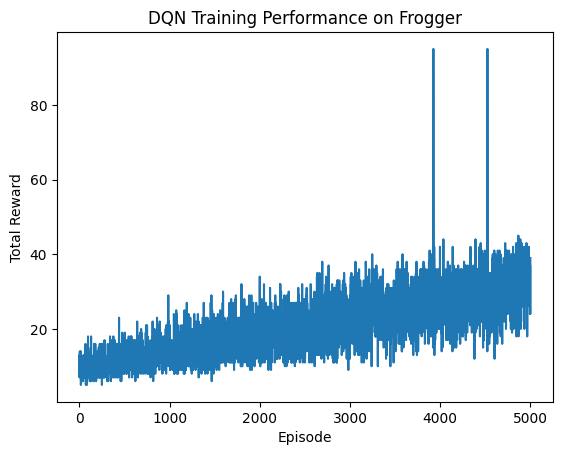

In [6]:
# Create the Atari environment

env = gym.make("ALE/Frogger-v5", render_mode="rgb_array")  # Create Atari env

env = GrayscaleObservation(env, keep_dim=False)
env = ResizeObservation(env, (84, 84))

env = wrap_deepmind(env, episode_life=False, clip_rewards=False, frame_stack=True, scale=False)

# Check Action / State space
obs, info = env.reset()

action_dim = env.action_space.n
print(f"Observation space: {env.observation_space}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dqn = DQN_CNN(4, action_dim).to(device)
target_dqn = DQN_CNN(4, action_dim).to(device)
target_dqn.load_state_dict(dqn.state_dict())

optimizer = optim.Adam(dqn.parameters(), lr=0.0001)
replay_buffer = ReplayBuffer(10000)

num_episodes = 5000
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.9995
target_update_freq = 100
rewards_list = []

for episode in range(num_episodes):
    state, info = env.reset()
    # skip first 100 frames as no_op_frames
    for i in range(100):
      next_state, reward, done, truncated, info = env.step(0)

    state = np.array(next_state).squeeze()
    total_reward = 0
    done = False

    while not done:
        action = select_action(env, dqn, state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        next_state = np.array(next_state).squeeze()

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        train(dqn, target_dqn, replay_buffer, optimizer, batch_size, gamma)

    rewards_list.append(total_reward)

    if episode % target_update_freq == 0:
        target_dqn.load_state_dict(dqn.state_dict())
        torch.save(dqn.state_dict(), f"frogger_dqn_model_{episode}.pth")

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

plt.plot(rewards_list)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance on Frogger")
plt.show()

# store the model
torch.save(dqn.state_dict(), "frogger_dqn_model.pth")
# save the rewards_list in a txt file with comma separated
np.savetxt("frogger_dqn_rewards.txt", rewards_list, delimiter=",")

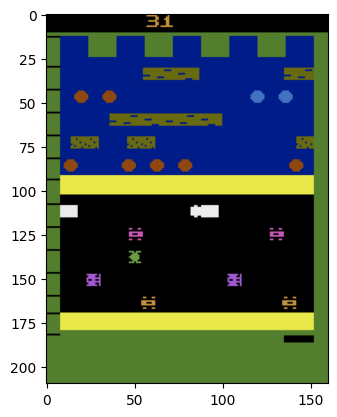

Total Steps: 490


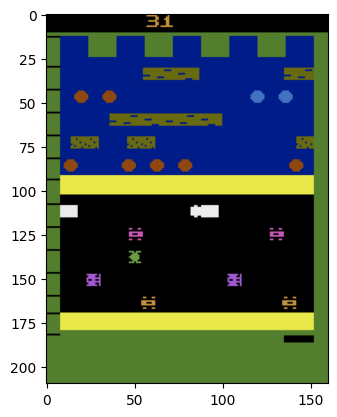

In [11]:
import os

os.makedirs('dqn/frames', exist_ok=True)

# draw dqn playing game
state, info = env.reset()
state = np.array(state).squeeze()
done = False
step = 0
while not done:
    step += 1
    action = select_action(env, dqn, state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

    if done:
        break

    img = env.render()
    # store frame as pngs
    plt.imsave(f"./dqn/frames/frame_{step}.png", img)
    plt.imshow(img)
    clear_output(wait=True)
    display(plt.gcf())
print(f"Total Steps: {step}")
env.close()

In [12]:
import os
os.system("ffmpeg -i dqn/frames/frame_%01d.png -vcodec mpeg4 -y dqn/trajectory.mp4")


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0